# **Machine Learning Models**

# **1. Library importing**

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('ggplot')
import matplotlib.gridspec as gridspec
import seaborn as sns
sns.set_style("darkgrid")
%matplotlib inline
pd.options.mode.chained_assignment = None
import matplotlib.font_manager
from scipy.stats import norm
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, auc
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.cluster import DBSCAN
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from typing import Dict, List
from sklearn import ensemble
import warnings
warnings.filterwarnings("ignore")
import plotly.figure_factory as ff
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot


In [ ]:
!pip install --upgrade statsmodels
import statsmodels.api as sm


In [ ]:
!pip install tensorflow

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2

## **3. Unsupervised Learning**
To explore performance of unsupervised learning methods, the project tests the performance of four different unsupervised methods, including Isolation Forest, One Class SVM, Local Outlier Factor, and Autoencoder.
-	Isolation Forest: This technique works by randomly selecting features and splitting data points. Anomalies, or outliers, are easier to isolate, resulting in shorter paths in the "forest." It's effective for large datasets, as it can quickly identify anomalies without needing to model the data's distribution. However, it may miss complex patterns since it relies on simple random splits.
-	One Class SVM: This model learns the boundary of normal data points and flags any points outside this boundary as anomalies. It's particularly powerful in high-dimensional spaces where traditional methods may struggle. However, it can be computationally intensive and sensitive to the presence of noise in the data, which can lead to misclassification.
-	Local Outlier Factor (LOF): LOF assesses the local density of each data point compared to its neighbours. If a point has a significantly lower density than those around it, it's considered an outlier. This technique is useful for identifying anomalies in varying densities, but it can be sensitive to the choice of the number of neighbours, which affects its performance.
-	Autoencoder: These are neural networks designed to compress and reconstruct data. By training on normal transactions, they learn to recreate them effectively. If a transaction cannot be reconstructed well, it's flagged as an anomaly. Autoencoders are great for capturing complex patterns in data, but they require more computational resources and careful tuning of architecture and parameters to perform effectively.
In this Appendix 3, the project provides further discuss related to the performance of each unsupervised learning methods when using full original dataset and the high-correlated one, which include 11 variables that have correlation with ‘Class’ ≥ 0.1 as mentioned before.

## **3.1. Feature transformation**

Feature transformation plays an essential role in anomaly detection. Many anomaly detection techniques work best when the data follows a Gaussian (normal) distribution. If our features are skewed (i.e., they have long tails in one direction) or are on different scales, these algorithms may struggle to accurately identify normal data points and anomalies. This could lead to normal instances being wrongly flagged as outliers or genuine anomalies being overlooked.

According to our histogram plots, many of our features are highly skewed. To address this issue, we will apply log transformations; therefore, we will stabilize variance, reduce skewness, and enhance the interpretability of the data. This ensures that the characteristics of the data align more closely with the assumptions of the model, thereby improving its ability to accurately identify anomalies and enhancing the overall reliability of the detection process.

In [ ]:
#Features name
features = df.columns[:-1]

# Create a copy of the DataFrame to avoid changing the original
df_transformed = df.copy()

# Function to handle log transformation for skewed data
def log_transform_skewed(column):
    # For positive and zero values (log1p avoids log(0) errors)
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Compute skewness before transformation
skewness_before = df.skew()

# Apply transformation to skewed columns
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Compute skewness after transformation
skewness_after = df_transformed.skew()

# Compare skewness before and after
skewness_comparison = pd.DataFrame({
    'Skewness Before': skewness_before,
    'Skewness After': skewness_after
})

# Print the comparison
skewness_comparison


,Skewness Before,Skewness After
Time,-0.035568,-0.035568
V1,-3.280667,-0.364893
V2,-4.624866,-0.310128
V3,-2.240155,-0.315192
V4,0.676292,0.676292
V5,-2.425901,0.139077
V6,1.826581,0.804345
V7,2.553907,-0.112666
V8,-8.521944,-0.912642
V9,0.554680,0.554680


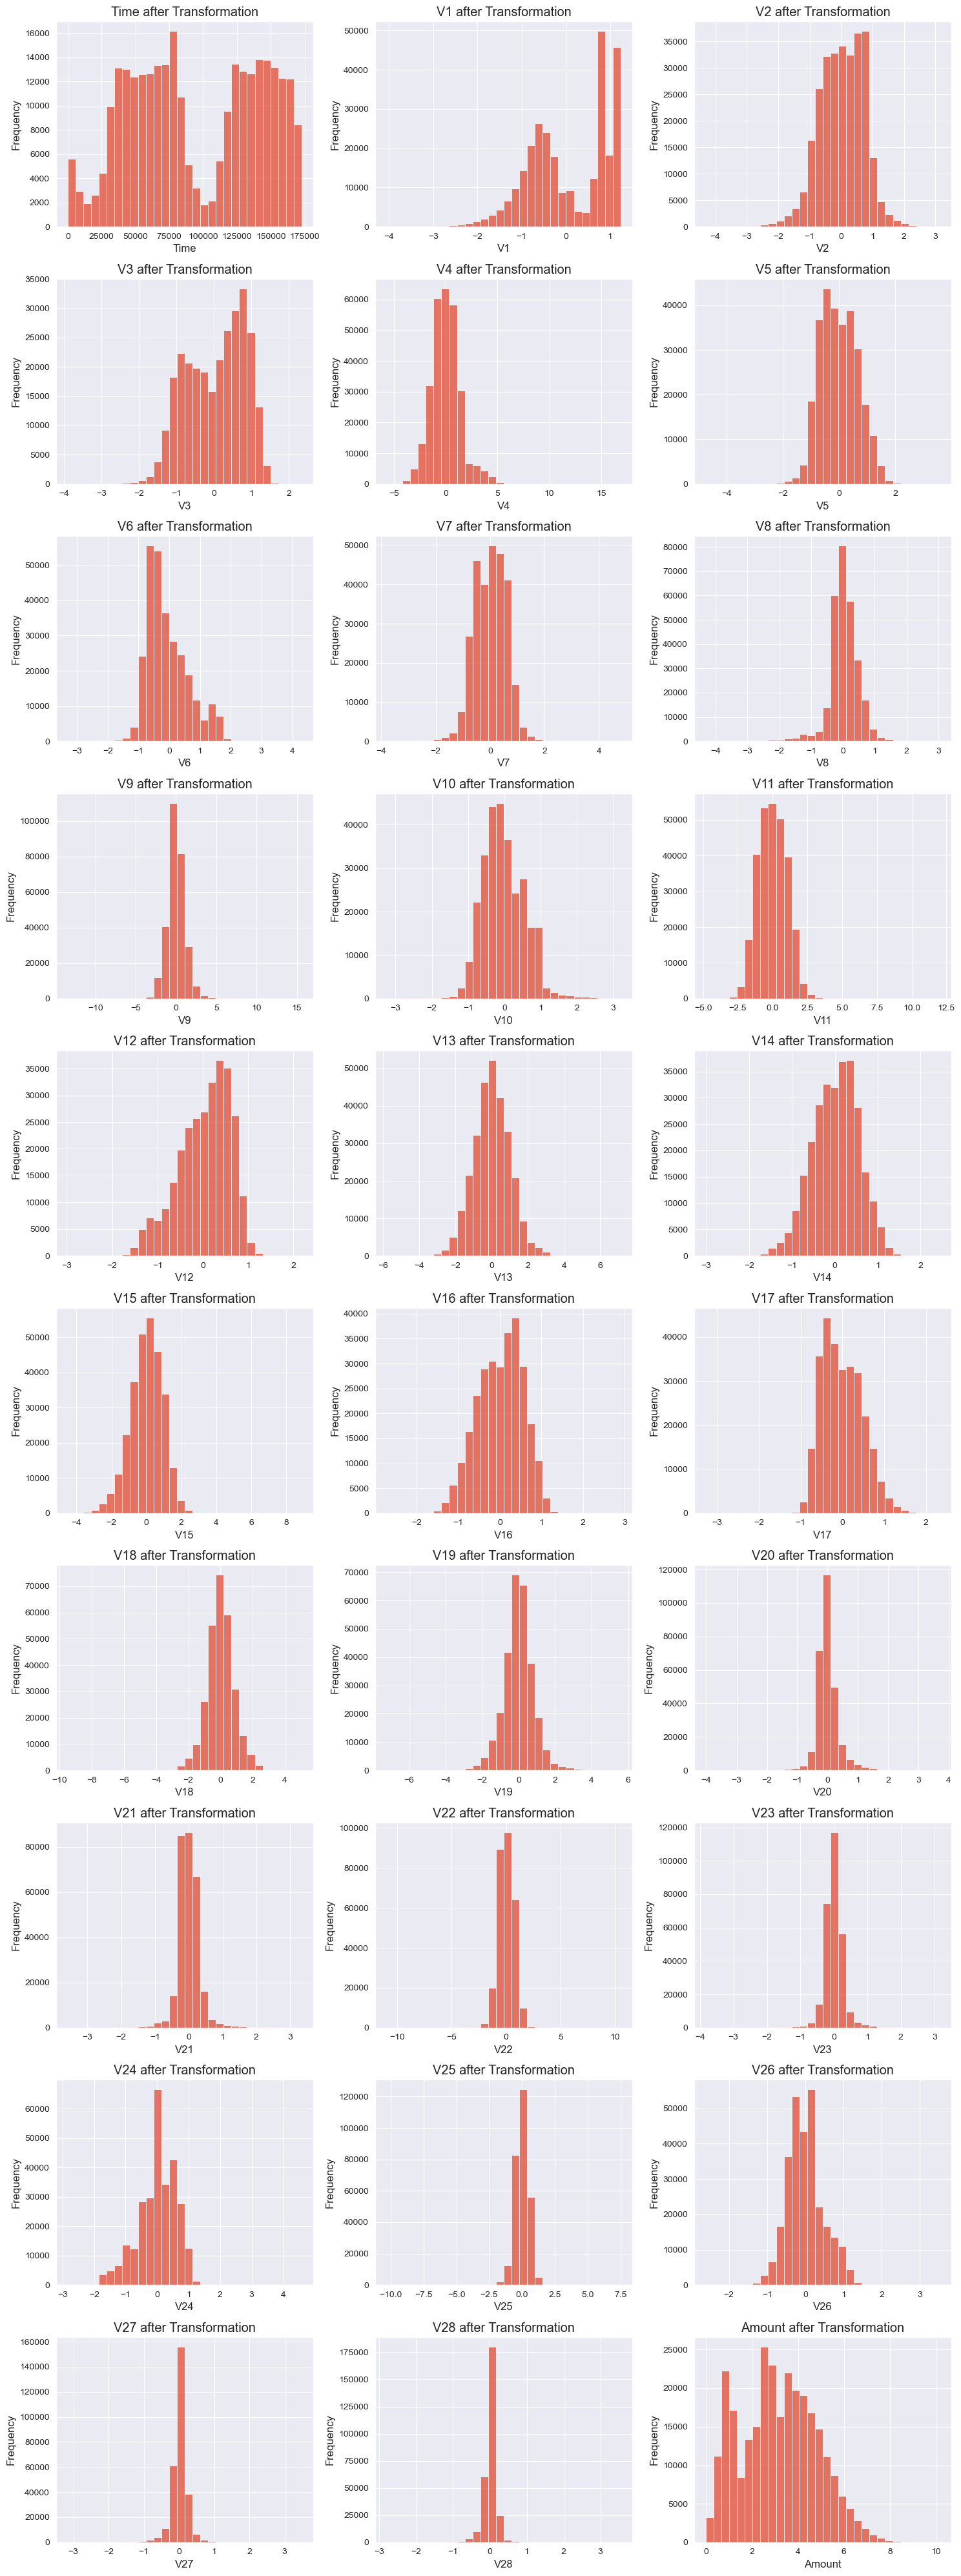

In [ ]:
# Set up the figure; 10 rows (10*3=30 subplots), adjust as needed
fig, axes = plt.subplots(10, 3, figsize=(15, 40))  # Adjust rows to fit all features

# Flatten axes array to loop through easily
axes = axes.flatten()

# Plot each feature in a separate subplot
for i, feature in enumerate(features):
    sns.histplot(df_transformed[feature], ax=axes[i], kde=False, bins=30)
    axes[i].set_title(f'{feature} after Transformation')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

# Remove any unused subplots if features < 30
for i in range(len(features), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

In [ ]:
# Separate features and target
X = df_transformed[features]
y = df_transformed['Class']

from sklearn.preprocessing import MinMaxScaler
# Standardize the data
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
print(X)

            Time        V1        V2        V3        V4        V5        V6  \
0            0.0 -0.858580 -0.070255  1.263094  1.378155 -0.291416  0.380071   
1            0.0  0.784749  0.235981  0.153991  0.448154  0.058286 -0.079145   
2            1.0 -0.857964 -0.850221  1.020005  0.379780 -0.407595  1.029798   
3            1.0 -0.676139 -0.169933  1.027114 -0.863291 -0.010256  0.809686   
4            2.0 -0.769290  0.630067  0.935590  0.403034 -0.341597  0.091596   
...          ...       ...       ...       ...       ...       ...       ...   
284802  172786.0 -2.555763  2.404400 -2.382762 -2.066656 -1.850731 -1.282831   
284803  172787.0 -0.549732 -0.053617  1.110221 -0.738589  0.624991  0.721936   
284804  172788.0  1.071435 -0.263328 -1.446834 -0.557828  1.289375  1.394079   
284805  172788.0 -0.215466  0.425583  0.532104  0.689799 -0.320605  0.484712   
284806  172792.0 -0.427496 -0.173729  0.532589 -0.506271 -0.012468 -0.500543   

              V7        V8        V9  .

## **3.2. Isolation Forest**
This technique works by randomly selecting features and splitting data points. Anomalies, or outliers, are easier to isolate, resulting in shorter paths in the "forest." It's effective for large datasets, as it can quickly identify anomalies without needing to model the data's distribution. However, it may miss complex patterns since it relies on simple random splits.

In [ ]:
# Initialize the Isolation Forest
iso_forest = IsolationForest(contamination=0.05, random_state=101)   # high contamination to catch more fraud transactions

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
iso_preds = iso_forest.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
iso_preds = [1 if x == -1 else 0 for x in iso_preds]

# Evaluate the results
print(classification_report(y, iso_preds, digits=4))
roc_auc_iso = roc_auc_score(y, iso_preds)
print(f"ROC AUC Score:, {roc_auc_iso:.5f}")

              precision    recall  f1-score   support

           0     0.9997    0.9514    0.9750    284315
           1     0.0294    0.8516    0.0569       492

    accuracy                         0.9512    284807
   macro avg     0.5146    0.9015    0.5159    284807
weighted avg     0.9981    0.9512    0.9734    284807

ROC AUC Score:, 0.90151


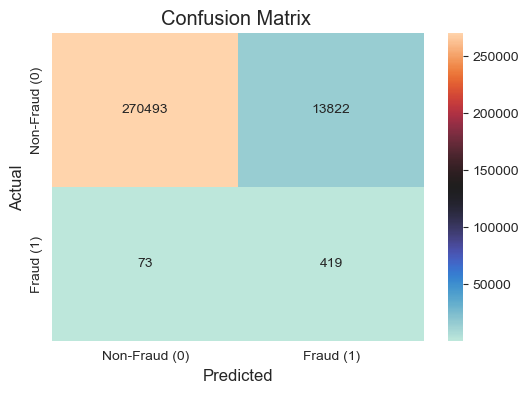

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, iso_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap = "icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [ ]:
# Get anomaly scores (the lower, the more anomalous)
iso_scores = -iso_forest.decision_function(X_scaled)

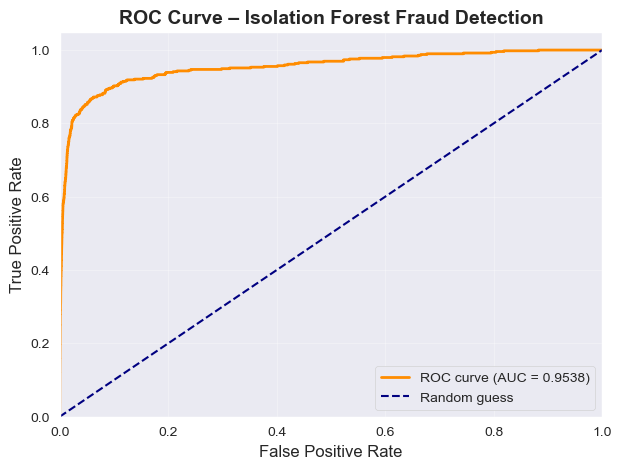

ROC AUC (using anomaly scores): 0.9538343406753274


In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, iso_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve – Isolation Forest Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Also print ROC AUC using the raw scores
roc_auc_score_value = roc_auc_score(y, iso_scores)
print("ROC AUC (using anomaly scores):", roc_auc_score_value)

The **Isolation Forest** is the best model that takes a short amount of time while achieving high overall accuracy (95.12%) and a strong ROC AUC (0.90151). Thereby, this model is generally good at distinguishing fraudulent from normal transactions. However, although the overall performance of this unsupervised method is most effective compared to other anomaly detection techniques, there is still a generous number of false negatives and positives. The detection of this model, therefore, should be an input to support the bigger hybrid model for fraud detection, or it would need post-filter or secondary validation to reduce false positives.

## **3.3. One Class SVM**
One Class SVM showed slightly better performance than Isolation Forest, but it takes too much time to conduct for a large dataset. This disadvantage makes this approach not suitable for real-life applications or applying to hybrid models.




In [ ]:
# Initialize One-Class SVM
oc_svm = OneClassSVM(kernel='rbf', gamma=0.001, nu=0.05)

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
svm_preds = oc_svm.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
svm_preds = [1 if x == -1 else 0 for x in svm_preds]

# Evaluate the results
print(classification_report(y, svm_preds, digits=4))
roc_auc_svm = roc_auc_score(y, svm_preds)
print(f"ROC AUC Score:, {roc_auc_svm:.5f}")
print("Confusion Matrix:")


              precision    recall  f1-score   support

           0     0.9997    0.9514    0.9750    284315
           1     0.0293    0.8496    0.0567       492

    accuracy                         0.9512    284807
   macro avg     0.5145    0.9005    0.5158    284807
weighted avg     0.9981    0.9512    0.9734    284807

ROC AUC Score:, 0.90048
Confusion Matrix:


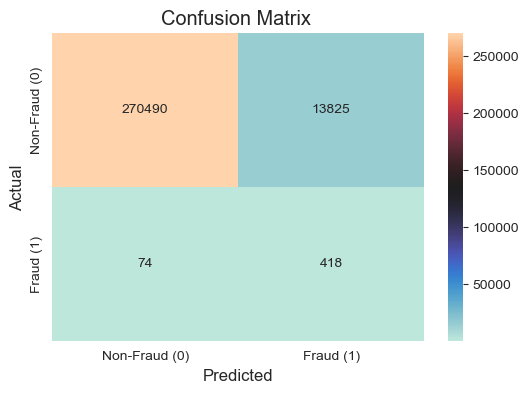

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, svm_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap = "icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

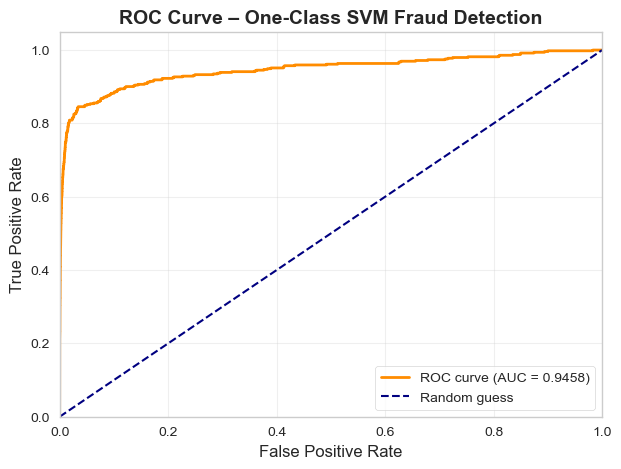

ROC AUC (using continuous scores): 0.9458170822497489


In [ ]:
# Get continuous anomaly scores from the SVM
# Higher scores → more normal; lower → more anomalous
svm_scores = -oc_svm.decision_function(X_scaled)  # negate to align higher = more likely fraud

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, svm_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve – One-Class SVM Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Optional: print ROC AUC using continuous scores
roc_auc_score_value = roc_auc_score(y, svm_scores)
print("ROC AUC (using continuous scores):", roc_auc_score_value)

One-class SVM shows similar patterns recall with Isolation Forest (0.8496) but having a slightly worse performance; furthermore, its time-consuming nature may limit its practical application in real-time fraud detection systems

## **3.4. Local Outlier Factor (LOF)**
 LOF assesses the local density of each data point compared to its neighbors. If a point has a significantly lower density than those around it, it's considered an outlier. This technique is useful for identifying anomalies in varying densities but can be sensitive to the choice of the number of neighbors, which affects its performance.



In [ ]:
# Initialize Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=10, contamination=0.05)

# Predict (returns -1 for anomalies and 1 for normal data)
lof_preds = lof.fit_predict(X_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
lof_preds = [1 if x == -1 else 0 for x in lof_preds]

# Evaluate the results
print(classification_report(y, lof_preds, digits=4))
roc_auc_lof = roc_auc_score(y, lof_preds)
print(f"ROC AUC Score:, {roc_auc_lof:.5f}")
print("Confusion Matrix:")
print(confusion_matrix(y, lof_preds))

              precision    recall  f1-score   support

           0     0.9983    0.9500    0.9736    284315
           1     0.0025    0.0711    0.0048       492

    accuracy                         0.9485    284807
   macro avg     0.5004    0.5106    0.4892    284807
weighted avg     0.9966    0.9485    0.9719    284807

ROC AUC Score:, 0.51059
Confusion Matrix:
[[270109  14206]
 [   457     35]]


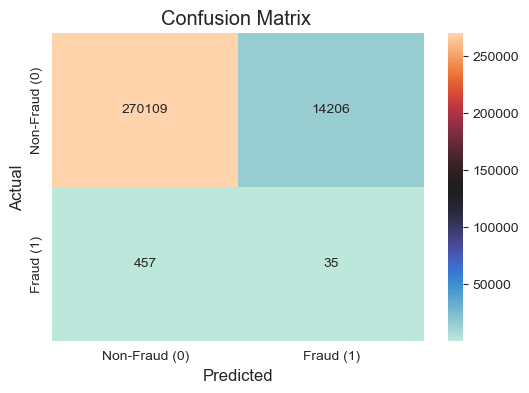

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, lof_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap = "icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

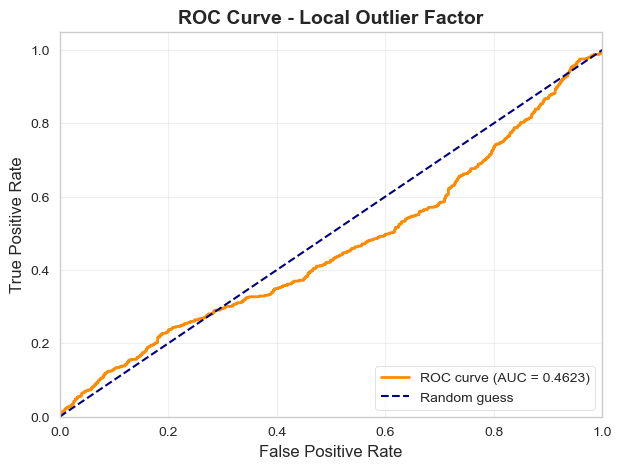

ROC AUC (using continuous scores): 0.46234609814575006


In [ ]:
# Get anomaly scores (higher = more anomalous)
lof_scores = -lof.negative_outlier_factor_

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, lof_scores)
roc_auc = roc_auc_score(y, lof_scores)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Local Outlier Factor', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Optional: print ROC AUC using continuous scores
roc_auc_score_value = roc_auc_score(y, lof_scores)
print("ROC AUC (using continuous scores):", roc_auc_score_value)

Local Outlier Factor is the worst anomaly detection algorithm since it can only recall 7.11% fraud transactions (detected 35/ 492 fraud transactions), while having more false negatives and positives than Isolation Forest and One Class SVM. This might be because the credit set is highly imbalanced with high dimensionality. Thus, the local density approach fails to distinguish rare frauds from dense normal clusters, leading to very low recall. Overall, the outcome of LOF is even worse than a random guess, as it is shown in the ROC Curve figure.

## **3.5. Autoencoders**

These are neural networks designed to compress and reconstruct data. By training on normal transactions, they learn to recreate them effectively. If a transaction cannot be reconstructed well, it's flagged as an anomaly. Autoencoders are great for capturing complex patterns in data, but they require more computational resources and careful tuning of architecture and parameters to perform effectively.

In [ ]:
# Define the autoencoder model
def build_autoencoder(input_dim):
    input_layer = Input(shape=(input_dim,))

      # Encoder
    encoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(encoded)
    encoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(encoded)

  # Latent space
    latent = Dense(4, activation='relu')(encoded)

# Decoder
    decoded = Dense(8, activation='relu', kernel_regularizer=l2(0.001))(latent)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    decoded = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(decoded)
    output_layer = Dense(input_dim, activation='linear')(decoded)

    autoencoder = Model(inputs=input_layer, outputs=output_layer)
    return autoencoder

In [ ]:
# Build and compile the model
autoencoder = build_autoencoder(X_scaled.shape[1])
autoencoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Train the model on normal transactions (non-fraudulent class, y == 0)
X_train = X_scaled[y == 0]
autoencoder.fit(X_train, X_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

#Train on only the normal transaction data (y==0) to learn "normal behaviors, normal features" of the non-fraud transaction

# Calculate reconstruction error for all transactions
reconstructed = autoencoder.predict(X_scaled)
ae_mse = np.mean(np.power(X_scaled - reconstructed, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(ae_mse, 90)  # Adjust threshold (90th percentile)
autoen_preds = np.where(ae_mse > threshold, 1, 0)  # 1: anomaly (fraud), 0: normal

# Evaluate the model
print(classification_report(y, autoen_preds, digits=4))
roc_auc_ae = roc_auc_score(y, autoen_preds)
print(f"ROC AUC Score:, {roc_auc_ae:.5f}")

Epoch 1/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - loss: 0.0405 - val_loss: 0.0134
Epoch 2/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.0088 - val_loss: 0.0132
Epoch 3/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.0087 - val_loss: 0.0131
Epoch 4/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0087 - val_loss: 0.0131
Epoch 5/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 30s 4ms/step - loss: 0.0087 - val_loss: 0.0133
Epoch 6/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0087 - val_loss: 0.0134
Epoch 7/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0087 - val_loss: 0.0132
Epoch 8/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0087 - val_loss: 0.0135
Epoch 9/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 32s 4ms/step - loss: 0.0087 - val_loss: 0.0133
Epoch 10/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 0.0087 - val_loss: 0.0132
Epoch 11/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 41s 4ms/step - loss: 0.0087 - val_loss: 0.0131
Epoch 12/50
7997/79

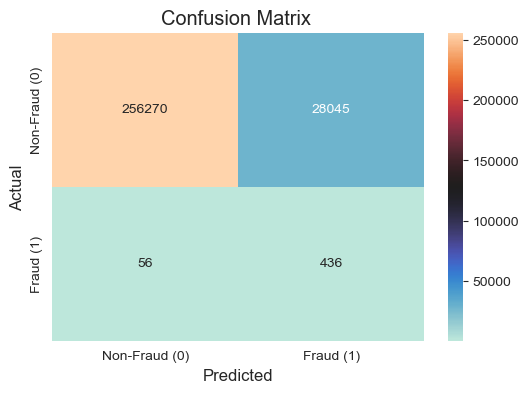

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

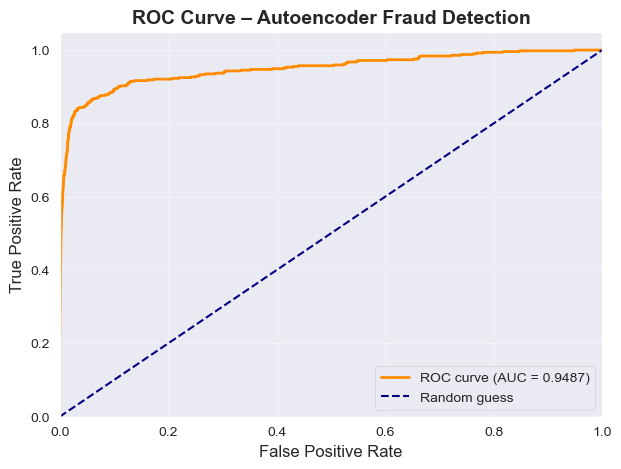

In [ ]:
# Use reconstruction errors (MSE) as continuous anomaly scores
fpr, tpr, thresholds = roc_curve(y, ae_mse)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve – Autoencoder Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

Autoencoders showed a strong balance between recall (0.8943) and accuracy (0.90). Despite its low precision (0.0154), its ability to capture most frauds makes it suitable and worthwhile for trade off, since it is often better to flag more potential cases for review than to miss real frauds.

Compared with other unsupervised approaches, the Autoencoder demonstrates relatively strong performance in detecting the normal class. Based on the confusion matrix, the model identifies a greater number of fraudulent instances than both the Isolation Forest and One-Class SVM, while simultaneously producing fewer false positives. This indicates that the Autoencoder achieves a more balanced performance in fraud detection. Moreover, the model exhibits reasonable computational efficiency. Therefore, the Autoencoder is considered a valuable component to support the Hybrid model developed and evaluated in this project.

# **4. Anomaly Detection with High-correlated features**

As detected from the Exploration Data Analysis part, 11 features have absolute correlations with ‘Class’ ≥ 0.1. The project further examined the performances of the two chosen models (Isolation Forest and Autoencoder) on a highly correlated features dataset. The results show that there are clear improvements in detecting fraudulent transactions, with the values of recall (1) increasing (Isolation Forest: from 0.85 to 0.90; Autoencoder: from 0.87 to 0.91). The results once again prove the importance of these features in fraud detection modelling.

## **4.1. Data preparation (High-correlated set)**

In [ ]:
# Features that want to keep
cols_to_keep = ['V1', 'V3', 'V4', 'V7', 'V10', 'V11', 'V12', 'V14', 'V16', 'V17', 'V18']

# Z with high-correlated features
Z = X[cols_to_keep]

# Print Z
print(Z.head())

         V1        V3        V4        V7       V10       V11       V12  \
0 -0.858580  1.263094  1.378155  0.214788  0.086906 -0.551600 -0.481068   
1  0.784749  0.153991  0.448154 -0.075852 -0.154414  1.612727  0.725244   
2 -0.857964  1.020005  0.379780  0.583031  0.188670  0.624501  0.063992   
3 -0.676139  1.027114 -0.863291  0.213181 -0.053495 -0.226487  0.164012   
4 -0.769290  0.935590  0.403034  0.465582  0.561371 -0.822843  0.430610   

        V14       V16       V17       V18  
0 -0.270919 -0.385535  0.188942  0.025791  
1 -0.134332  0.381116 -0.108679 -0.183361  
2 -0.153533 -1.358431  0.746673 -0.121359  
3 -0.253031 -0.722535 -0.521227  1.965775  
4 -0.751260 -0.372562 -0.212716 -0.038195  


In [ ]:
# Standardize the data
Z_scaled = scaler.fit_transform(Z)

## **4.2. Isolation Forest with High-correlated variables**

In [ ]:
# Initialize the Isolation Forest
iso_forest_imp = IsolationForest(contamination=0.05, random_state=101)   # high contamination to catch more fraud transactions

# Fit the model and predict (returns -1 for anomalies and 1 for normal data)
iso_imp_preds = iso_forest_imp.fit_predict(Z_scaled)

# Convert -1 (anomalies) to 1 (fraud) and 1 (normal) to 0 (non-fraud)
iso_imp_preds = [1 if x == -1 else 0 for x in iso_imp_preds]

# Evaluate the results
print(classification_report(y, iso_imp_preds, digits=4))
roc_imp_auc = roc_auc_score(y, iso_imp_preds)
print(f"ROC AUC Score: {roc_imp_auc:.5f}")


              precision    recall  f1-score   support

           0     0.9998    0.9515    0.9750    284315
           1     0.0310    0.8963    0.0599       492

    accuracy                         0.9514    284807
   macro avg     0.5154    0.9239    0.5175    284807
weighted avg     0.9981    0.9514    0.9735    284807

ROC AUC Score:, 0.92390


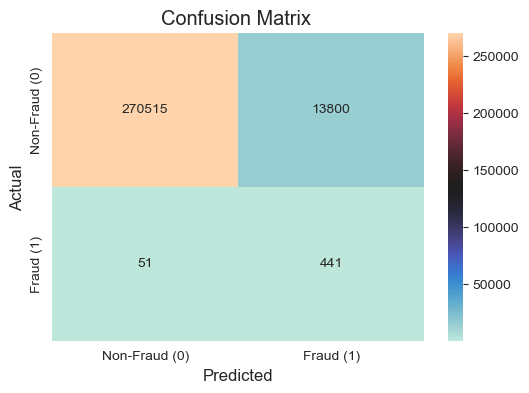

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, iso_imp_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap = "icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

In [ ]:
# Get anomaly scores (the lower, the more anomalous)
iso_imp_scores = -iso_forest_imp.decision_function(Z_scaled)

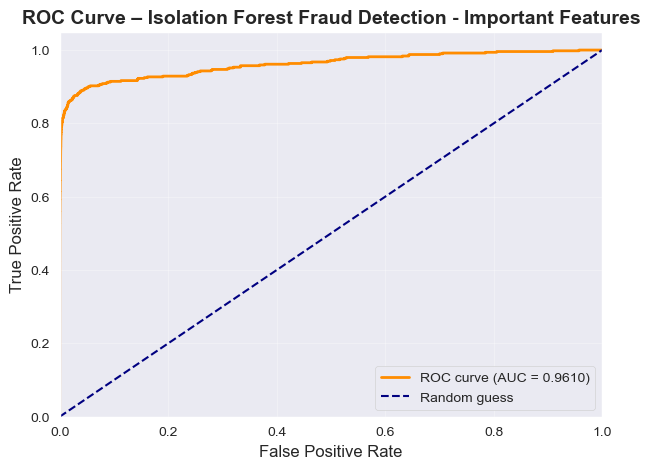

ROC AUC (using anomaly scores): 0.9609644075354986


In [ ]:
# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, iso_imp_scores)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve – Isolation Forest Fraud Detection - Important Features', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Also print ROC AUC using the raw scores
roc_auc_score_value = roc_auc_score(y, iso_imp_scores)
print("ROC AUC (using anomaly scores):", roc_auc_score_value)

This method achieved higher recall for fraudulent transactions, increasing from 0.8516 to 0.8963. The F1-scores for the fraud class also improved slightly for Isolation Forest, reflecting a better balance between identifying frauds and limiting the number of false positives

## **4.3. Autoencoder with High-correlated variables**

In [ ]:
# Build and compile the model
autoencoder_imp = build_autoencoder(Z_scaled.shape[1])
autoencoder_imp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss='mse')

# Train the model on normal transactions (non-fraudulent class, y == 0)
Z_train = Z_scaled[y == 0]
autoencoder_imp.fit(Z_train, Z_train, epochs=50, batch_size=32, shuffle=True, validation_split=0.1)

#Train on only the normal transaction data (y==0) to learn "normal behaviors, normal features" of the non-fraud transaction

# Calculate reconstruction error for all transactions
reconstructed_imp = autoencoder_imp.predict(Z_scaled)
ae_mse_imp = np.mean(np.power(Z_scaled - reconstructed_imp, 2), axis=1)

# Set a threshold for anomaly detection
threshold = np.percentile(ae_mse_imp, 90)  # Adjust threshold (90th percentile)
autoen_imp_preds = np.where(ae_mse_imp > threshold, 1, 0)  # 1: anomaly (fraud), 0: normal

# Evaluate the model
print(classification_report(y, autoen_imp_preds, digits=4))
roc_auc_ae_imp = roc_auc_score(y, autoen_imp_preds)
print(f"ROC AUC Score: {roc_auc_ae_imp:.5f}")

Epoch 1/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 45s 5ms/step - loss: 0.0411 - val_loss: 0.0111
Epoch 2/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0097 - val_loss: 0.0097
Epoch 3/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 4/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 5/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 40s 5ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 6/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 37s 5ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 7/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 42s 5ms/step - loss: 0.0095 - val_loss: 0.0098
Epoch 8/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 41s 5ms/step - loss: 0.0095 - val_loss: 0.0096
Epoch 9/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 38s 5ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 10/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 34s 4ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 11/50
7997/7997 ━━━━━━━━━━━━━━━━━━━━ 47s 5ms/step - loss: 0.0095 - val_loss: 0.0097
Epoch 12/50
7997/79

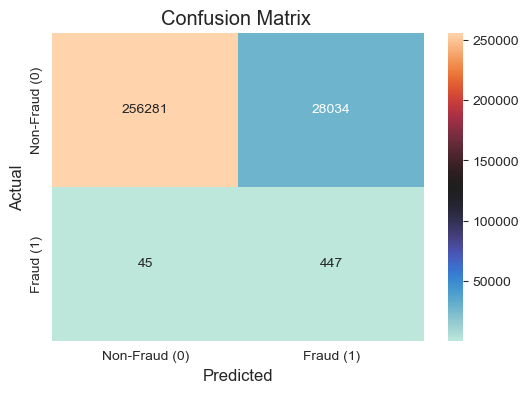

In [ ]:
# Plot the confusion matrix
cm = confusion_matrix(y, autoen_imp_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Confusion Matrix ')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

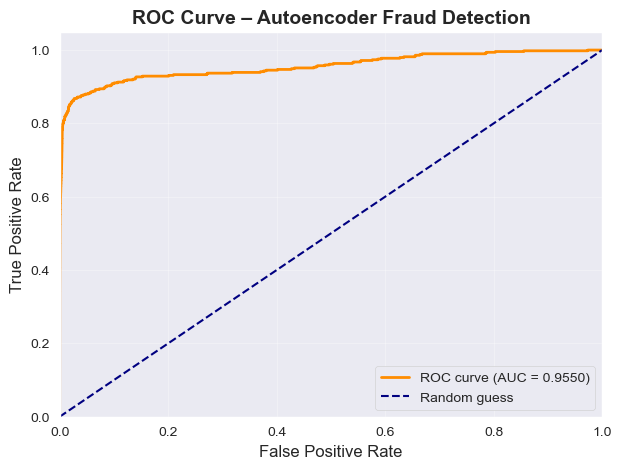

In [ ]:
# Use reconstruction errors (MSE) as continuous anomaly scores
fpr, tpr, thresholds = roc_curve(y, ae_mse_imp)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve – Autoencoder Fraud Detection', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## Summary
The project tested the fraud detection effectiveness of five different unsupervised learning algorithms. The outcomes show that Isolation Forest and One Class SVM demonstrated the highest accuracy rates in identifying fraudulent activity, followed by Autoencoder. Specifically, Isolation Forest performed well overall, achieving high recall (0.8516) for fraudulent cases and strong overall accuracy (0.9512). This indicates that it correctly detected most fraud while maintaining a good balance across classes. One-class SVM shows similar patterns recall but having a slightly worse performance; furthermore, its time-consuming nature may limit its practical application in real-time fraud detection systems. Autoencoders showed a strong balance between recall (0.8943) and accuracy (0.90). Despite its low precision (0.0154), its ability to capture most frauds makes it suitable and worthwhile for trade off, since it is often better to flag more potential cases for review than to miss real frauds. Local Outlier Factor, although the theory seems promising, its practical performance is worse with low precision, recall, and F1-score for fraud transactions (0.0025, 0.0711, and 0.0048, respectively). In summary, the results indicate that Isolation Forest and the Autoencoder are the most real-life applicable unsupervised models for fraud detection. 
The project further analysed the application of these 2 effective unsupervised learning algorithms by testing only on features with absolute correlations with ‘Class’ ≥ 0.1. The result shows that removing weak variables can reduce noise and allow the models to focus on the most relevant patterns and improve the accuracy of Isolation Forest and Autoencoder. As shown in Table X, both models achieved higher recall for fraudulent transactions, increasing from 0.8516 to 0.8963 for Isolation Forest and from 0.8943 to 0.9085 for the Autoencoder. This means the models were able to detect a larger proportion of actual fraud cases after weak features were excluded. The F1-scores for the fraud class also improved slightly for Isolation Forest, reflecting a better balance between identifying frauds and limiting the number of false positives. These results suggest that using unsupervised learning on higher correlation features further enhances the models’ sensitivity to meaningful anomalies, leading to stronger and more efficient unsupervised fraud detection performance.

# **5. Supervised Learning**

**Supervised Learning**

To evaluate the performance of different machine learning algorithms, the dataset is processed with SMOTE, and then separated into 2 small datasets, “train” and “test”, and then it is tested again with the full original data frame, which has not gone through any kind of processing. This will ensure the most accurate assessment and help us to recognise the possibility of real-life application. 

Overall, the results of supervised learning algorithms are much more precise than unsupervised ones. The Random Forest so far is the best performing model with the highest F1-score (0.9685), and according to its confusion matrix, there are no false negatives and 32 false positives. XGBoots and CatBoots both have good recalls and no false negatives, but XGBoots slightly performs better than CatBoots with higher Precision (1) and F1-score (1). On the other hand, AdaBoost and LightGBM have really poor overall balance with F1-score (1) equal to 0.1598 and 0.0144, respectively. LightGBM is the worst-performing with extremely low Precision (1) (0.0072), which is even lower than the Anomaly detection models’ performances, reflecting severe overprediction of the minority class. Furthermore, the results also showed that the most important features for the models are likely the ones that have better correlations with ‘Class’, but not all listed high correlation features have great contributions to the Machine Learning model. Therefore, the outcomes of detecting fraudulent transactions on highly correlated data frames are significantly worse than using the whole original one, indicating that the whole data frame must be used as an input for machine learning methods and hybrid methods that are based on supervised algorithms.

## **5.1. Data preposessing with SMOTE**

To evaluate the performance of different machine learning algorithms, the dataset is processed with SMOTE, and then separated into 2 small datasets, “train” and “test”, and then it is tested again with the full original dataframe, which has not gone through any kind of processing. This will ensure the most accurate assessment and help us to recognise the possibility of real-life application.

In [ ]:
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [ ]:
# Define dataset
def Definedata(df):
    X_smote = df.drop(columns=['Class']).values
    y_smote = df['Class'].values
    return X_smote, y_smote

In [ ]:
def ApplySMOTE(df, test_size=0.5, random_state=2):
    X_smote, y_smote = Definedata(df)

    # summarize class distribution
    counter = Counter(y_smote)
    print("Original class distribution:", counter)

    # apply SMOTE
    smt = SMOTE(random_state=0)
    X_res, y_res = smt.fit_resample(X_smote, y_smote)

    # summarize new class distribution
    counter_res = Counter(y_res)
    print("After SMOTE class distribution:", counter_res)

    # split train/test
    X_train, X_test, y_train, y_test = train_test_split(
        X_res, y_res, test_size=test_size, random_state=random_state
    )

    # optional: scatter plot for first 2 features
    for label in np.unique(y_res):
        row_ix = np.where(y_res == label)
        plt.scatter(X_res[row_ix, 0], X_res[row_ix, 1], label=str(label))
    plt.legend()
    plt.title("SMOTE Data Distribution (first 2 features)")
    plt.show()

    return X_train, X_test, y_train, y_test

In [ ]:
# Train model and plot confusion matrices
def Models(model, X_train, X_test, y_train, y_test, df, title="Model", cmap='icefire'):
    # train model
    model.fit(X_train, y_train)

    # full dataset
    X_all, y_all = Definedata(df)

    # confusion matrices
    train_matrix = pd.crosstab(y_train, model.predict(X_train), rownames=['Actual'], colnames=['Predicted'])
    test_matrix = pd.crosstab(y_test, model.predict(X_test), rownames=['Actual'], colnames=['Predicted'])
    full_matrix = pd.crosstab(y_all, model.predict(X_all), rownames=['Actual'], colnames=['Predicted'])

    # plot heatmaps
    f, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(20, 4))

    sns.heatmap(train_matrix, annot=True, fmt="d", cbar=False, ax=ax1, cmap=cmap)
    ax1.set_title(f"{title} - Training Set")
    ax1.set_xlabel(f"Accuracy: {accuracy_score(y_train, model.predict(X_train)):.4f}")

    sns.heatmap(test_matrix, annot=True, fmt="d", cbar=False, ax=ax2, cmap=cmap)
    ax2.set_title(f"{title} - Testing Set")
    ax2.set_xlabel(f"Accuracy: {accuracy_score(y_test, model.predict(X_test)):.4f}")

    sns.heatmap(full_matrix, annot=True, fmt="d", cbar=False, ax=ax3, cmap=cmap)
    ax3.set_title(f"{title} - Full Dataset")
    ax3.set_xlabel(f"Accuracy: {accuracy_score(y_all, model.predict(X_all)):.4f}")

    plt.show()

    return model, model.predict(X_all)

In [ ]:
# Feature importances
def FeatureImportances(model, X_train, y_train, df):
    # Fit model
    model.fit(X_train, y_train)

    # Feature importance
    importances = model.feature_importances_
    features = df.drop(columns=['Class']).columns

    # Create dataframe
    imp = pd.DataFrame({'Feature': features, 'Importance': importances})

    # Cumulative Importance
    imp['Cumulative Importance'] = imp['Importance'].cumsum()

    # Sort importance
    imp = imp.sort_values(by='Importance', ascending = False).reset_index(drop=True)

    return imp

Original class distribution: Counter({np.int64(0): 284315, np.int64(1): 492})
After SMOTE class distribution: Counter({np.int64(0): 284315, np.int64(1): 284315})


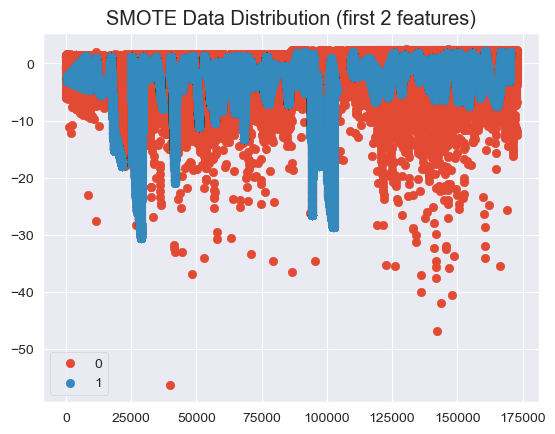

In [ ]:
# Apply SMOTE
X_train, X_test, y_train, y_test = ApplySMOTE(df)

## **5.2. Random Forest**

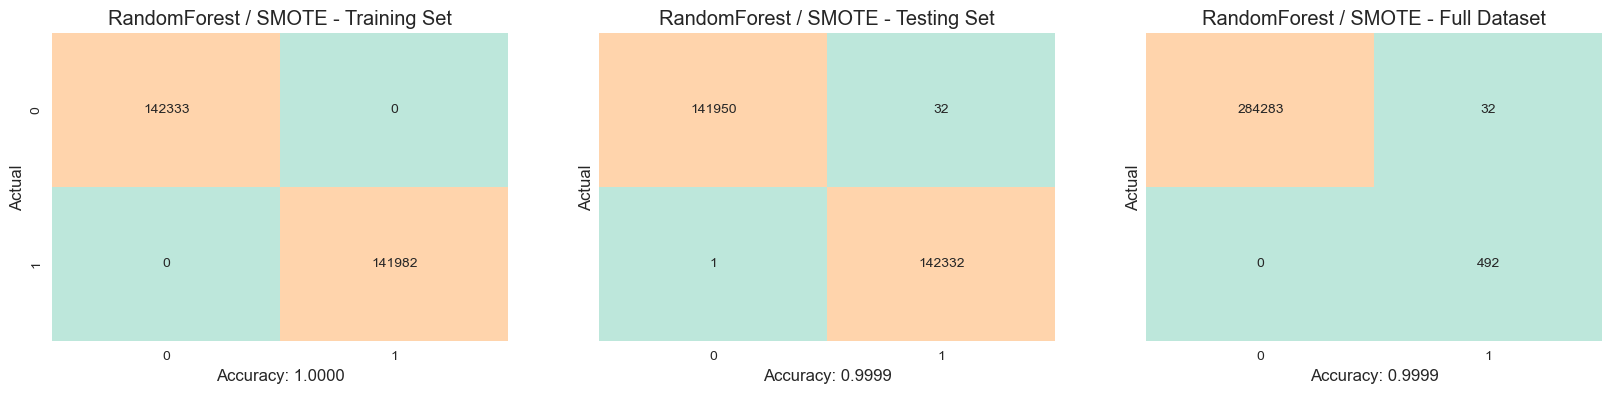

In [ ]:
# Train RandomForest model
rf_model = RandomForestClassifier(random_state=0)
model, y_pred = Models(rf_model, X_train, X_test, y_train, y_test, df, title="RandomForest / SMOTE")

In [ ]:
# Feature importances
imp_df = FeatureImportances(rf_model, X_train, y_train, df)
print(imp_df)

   Feature  Importance  Cumulative Importance
0      V14    0.250285               0.855040
1      V10    0.177638               0.433753
2       V4    0.102990               0.192582
3      V12    0.097679               0.599800
4      V11    0.068367               0.502120
5      V16    0.051221               0.910159
6       V3    0.042957               0.089592
7      V17    0.030540               0.940699
8       V2    0.028953               0.046635
9       V7    0.017694               0.231475
10      V9    0.017217               0.256115
11      V6    0.014956               0.213782
12     V21    0.010976               0.969616
13      V1    0.010119               0.017683
14     V18    0.009344               0.950043
15    Time    0.007564               0.007564
16      V8    0.007423               0.238899
17      V5    0.006244               0.198825
18     V27    0.005277               0.991734
19     V13    0.004955               0.604754
20     V19    0.004435            

After being trained and tested on the processed dataset, the Random Forest model is evaluated on the full original dataset. The result shows that the Random Forest model has successfully learned and can detect all the fraudulent transactions, with an accuracy equal to 99.99%. The confusion matrix shows that the model just has 32 false positives, a significantly smaller amount compared to other tested methods in this project. In addition, the model has 100% recall and ~94% precision, which means that the model is sensitive to fraudulent transactions.

Furthermore, the dataset is heavily dominated by a few core components, which are V14, V10, V4, V12, V11, V16, V3, and V17. These are 8/11 highly correlated features that are mentioned in the EDA par; these features are principal components that reflect the strong variance related to fraud patterns. For this supervised model, these features account for over 82% of all importance.

In [ ]:
# Full dataset
X_all, y_all = Definedata(df)

In [ ]:
# Classification report
report = classification_report(y_all, y_pred, digits=4)
print("Classification Report (Full Dataset)")
print(report)

# Get probabilities for the positive class (Class=1)
y_proba_rf = rf_model.predict_proba(X_all)[:, 1]

# ROC-AUC
roc_auc_rf = roc_auc_score(y_all, y_proba_rf)
print(f"ROC AUC Score (Full Dataset): {roc_auc_rf:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(cm.shape[0])],
                     columns=[f"Pred_{i}" for i in range(cm.shape[1])])
print("Confusion Matrix (Full Dataset):")
print(cm_df)


Classification Report (Full Dataset)
              precision    recall  f1-score   support

           0     1.0000    0.9999    0.9999    284315
           1     0.9389    1.0000    0.9685       492

    accuracy                         0.9999    284807
   macro avg     0.9695    0.9999    0.9842    284807
weighted avg     0.9999    0.9999    0.9999    284807

ROC AUC Score (Full Dataset): 0.99999
Confusion Matrix (Full Dataset):
          Pred_0  Pred_1
Actual_0  284283      32
Actual_1       0     492


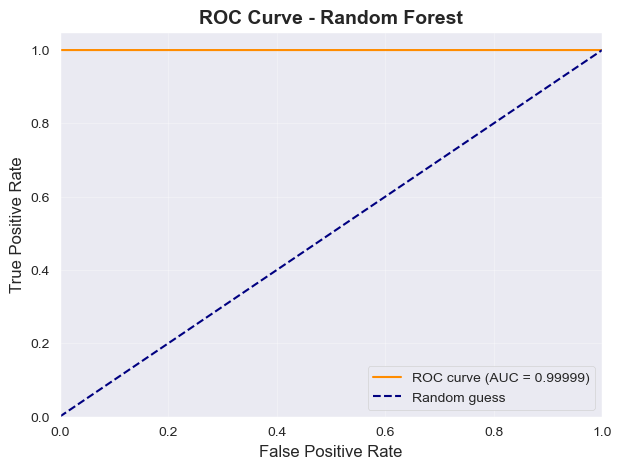

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, y_proba_rf)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc_rf:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Random Forest', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Calculate Gini coefficient
gini = 2 * roc_auc_rf - 1
print(f"Gini Coefficient: {gini:.4f}")

Gini Coefficient: 0.8970


The ROC Curve shows that the model has good performance, and with the Gini Coefficient (GINI) approximately 1.0000. The Random Forest has been proven to have an excellent performance

## **5.3. XGBoost**

Overall: The XGBoost is the second most effective supervised algorithm, which has successfully detected all the fraud transactions, but has 72 false positives, 1.25 times more than that of Random Forest. However, compared to other models, the performance of XGBoost is highly pleasing

In [ ]:
!pip install xgboost
from xgboost import XGBClassifier

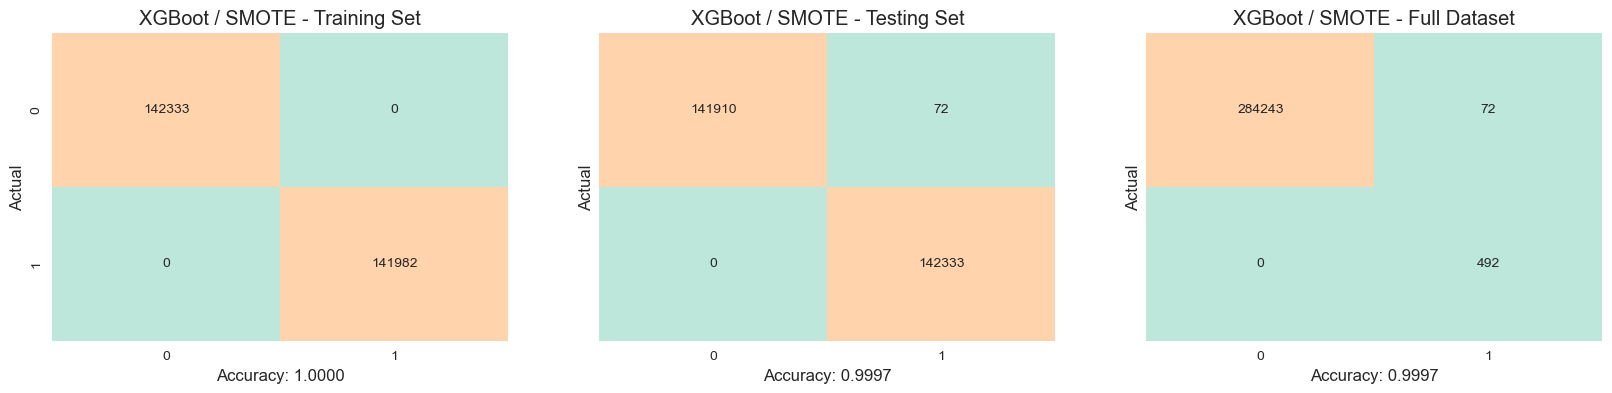

In [ ]:
# Train XGBoots model
xgb_model = XGBClassifier(random_state=0)
model, y_pred = Models(xgb_model, X_train, X_test, y_train, y_test, df, title="XGBoot / SMOTE")

In [ ]:
# Feature importances
imp_df = FeatureImportances(xgb_model, X_train, y_train, df)
print(imp_df)

   Feature  Importance  Cumulative Importance
0      V14    0.686158               0.877947
1       V4    0.049101               0.086606
2      V12    0.038648               0.182319
3      V17    0.033128               0.926201
4       V8    0.014026               0.116593
5       V3    0.013963               0.037505
6       V1    0.012154               0.019528
7      V11    0.010956               0.143671
8      V10    0.010065               0.132715
9      V19    0.009492               0.942271
10     V13    0.009470               0.191789
11  Amount    0.009441               1.000000
12     V15    0.008890               0.886837
13     V28    0.007497               0.990559
14     V23    0.007450               0.963867
15    Time    0.007375               0.007375
16     V18    0.006577               0.932778
17     V16    0.006236               0.893073
18      V6    0.006225               0.097054
19     V25    0.006173               0.973995
20     V26    0.006086            

The decision-making process of this model is largely driven by the top 4 components, including V14, V4, V1,2 and V17. These features account for approximately 90.7% of the feature importance. Among them, V14 stands out as the dominant predictor with an importance value of over 68.8%. It suggests that V14 carries substantial discriminative information that enables the model to effectively separate fraud transactions from the norm. The other features in the top four contribute moderately, with importance scores ranging between 0.03 and 0.05. However, these values are still higher than those of the remaining features, which have importance scores of 0.01 or lower.

In [ ]:
# Full dataset
X_all, y_all = Definedata(df)

# Classification report
report = classification_report(y_all, y_pred, digits=4)
print("Classification Report (Full Dataset)")
print(report)

# Get probabilities for the positive class (Class=1)
y_proba_xgb = xgb_model.predict_proba(X_all)[:, 1]

# ROC-AUC
roc_auc_xgb = roc_auc_score(y_all, y_proba_xgb)
print(f"ROC AUC Score (Full Dataset): {roc_auc_xgb:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(cm.shape[0])],
                     columns=[f"Pred_{i}" for i in range(cm.shape[1])])
print("Confusion Matrix (Full Dataset):")
print(cm_df)


Classification Report (Full Dataset)
              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9999    284315
           1     0.8723    1.0000    0.9318       492

    accuracy                         0.9997    284807
   macro avg     0.9362    0.9999    0.9658    284807
weighted avg     0.9998    0.9997    0.9998    284807

ROC AUC Score (Full Dataset): 0.99998
Confusion Matrix (Full Dataset):
          Pred_0  Pred_1
Actual_0  284243      72
Actual_1       0     492


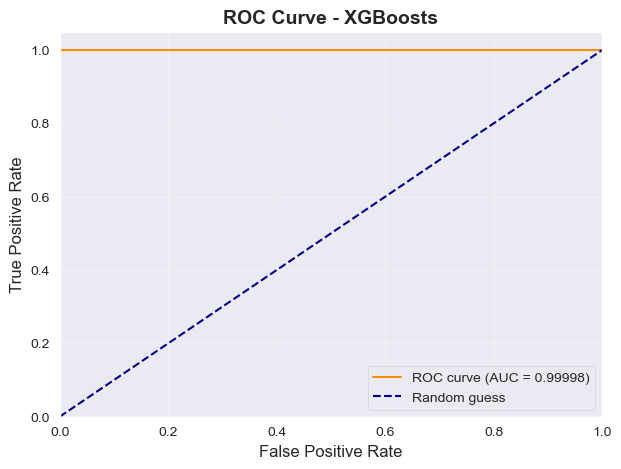

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, y_proba_xgb)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc_xgb:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - XGBoosts', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Calculate Gini coefficient
gini_xgb = 2 * roc_auc_xgb - 1
print(f"Gini Coefficient of XGBoosts: {gini_xgb:.4f}")

Gini Coefficient of XGBoosts: 1.0000


Similar to Random Forest, the ROC Curve of XGBoost model shows that the model has excellent performance, and with the Gini Coefficient (GINI) approximately 1.0000. 

## **5.4. AdaBoost Classifier**

Overall: The performance of the AdaBoost model surpasses that of the unsupervised approaches; however, it remains inferior to the XGBoost and Random Forest models. Specifically, AdaBoost successfully identified approximately 90% of fraudulent transactions but exhibited a relatively low precision (0.0877), meaning that a high incidence of false alarms and according to the confusion matrix, mostly fell into false positives. Nevertheless, with an overall accuracy of 0.9836, the AdaBoost model can still be regarded as a reasonably effective classification method within this context.

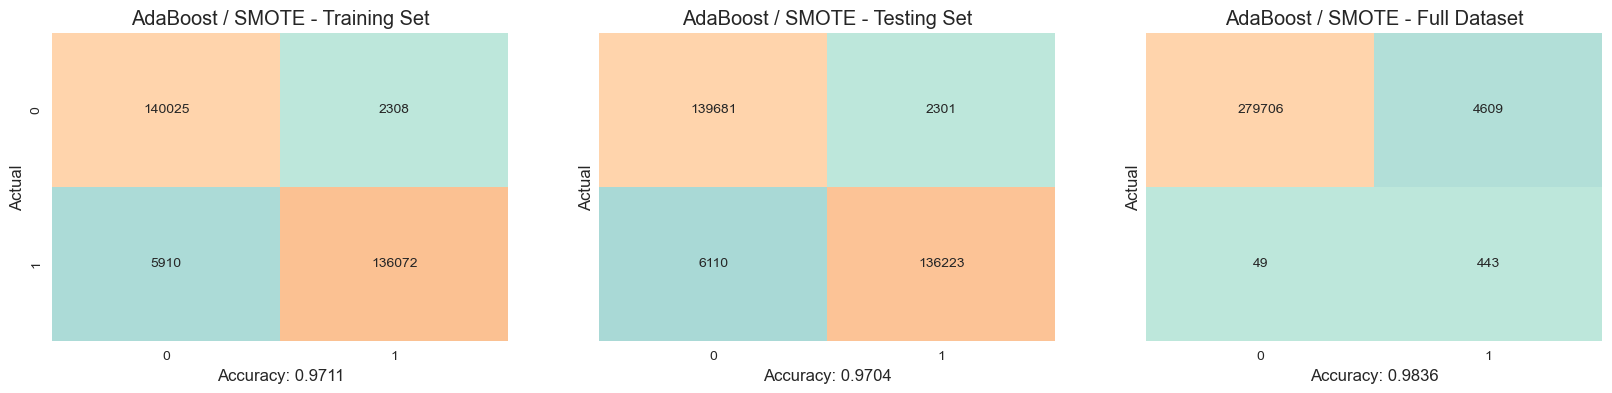

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# Train AdaBoost model
ada_model = AdaBoostClassifier(
    random_state=0,
    algorithm='SAMME',
    learning_rate=0.5,
    n_estimators=100
)

# Fit model and make predictions
model, y_pred = Models(ada_model, X_train, X_test, y_train, y_test, df, title="AdaBoost / SMOTE")

In [ ]:
# Feature importances
imp_df = FeatureImportances(ada_model, X_train, y_train, df)
print(imp_df)

   Feature  Importance  Cumulative Importance
0       V4    0.256805               0.409354
1      V14    0.179490               0.857148
2       V1    0.089257               0.102619
3      V10    0.084256               0.596361
4      V12    0.068312               0.677658
5       V3    0.049930               0.152550
6      V17    0.047868               0.950494
7      V16    0.045478               0.902626
8       V9    0.044831               0.512105
9       V8    0.028097               0.467274
10      V6    0.017116               0.426470
11     V21    0.015014               0.989553
12     V19    0.014434               0.974539
13    Time    0.013362               0.013362
14     V11    0.012985               0.609346
15      V7    0.012707               0.439176
16     V22    0.010447               1.000000
17     V18    0.009611               0.960105
18     V26    0.000000               1.000000
19     V24    0.000000               1.000000
20     V27    0.000000            

The top eight features account for 82.14% of the total feature importance in the AdaBoost model, indicating that these variables play a dominant role in shaping its predictive capability. Among them, V4 is identified as the most influential feature, contributing 23.68%, followed by V14 with 17.95%. These eight features show a strong correlation with the target variable (Class) and are also recognized as key predictors in the Random Forest model, suggesting consistency across different ensemble learning approaches.

In contrast, 12 features, including “Amount”, V2, V5, V13, V15, V20, and V23–V28, exhibit no measurable contribution to the model’s performance, implying that they provide minimal or redundant information for fraud detection within this dataset.


In [ ]:
# Full dataset
X_all, y_all = Definedata(df)

# Classification report
report = classification_report(y_all, y_pred, digits=4)
print("Classification Report (Full Dataset)")
print(report)

# Get probabilities for the positive class (Class=1)
y_proba_ada = ada_model.predict_proba(X_all)[:,1]

# ROC-AUC
roc_auc_ada = roc_auc_score(y_all, y_proba_ada)
print(f"ROC AUC Score (Full Dataset): {roc_auc_ada:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(cm.shape[0])],
                     columns=[f"Pred_{i}" for i in range(cm.shape[1])])
print("Confusion Matrix (Full Dataset):")
print(cm_df)

Classification Report (Full Dataset)
              precision    recall  f1-score   support

           0     0.9998    0.9838    0.9917    284315
           1     0.0877    0.9004    0.1598       492

    accuracy                         0.9836    284807
   macro avg     0.5438    0.9421    0.5758    284807
weighted avg     0.9982    0.9836    0.9903    284807

ROC AUC Score (Full Dataset): 0.98654
Confusion Matrix (Full Dataset):
          Pred_0  Pred_1
Actual_0  279706    4609
Actual_1      49     443


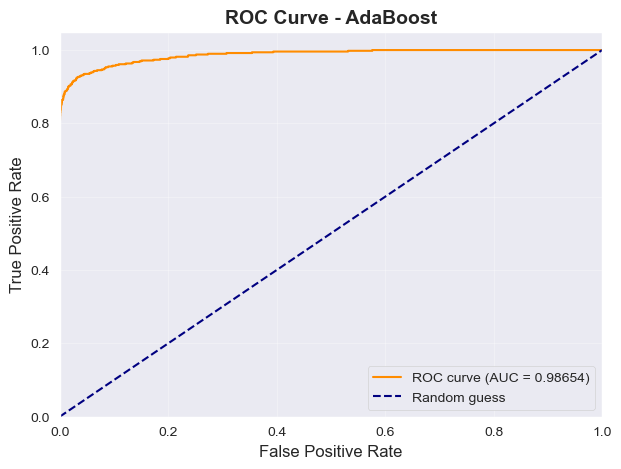

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, y_proba_ada)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc_ada:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - AdaBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Calculate Gini coefficient
gini_ada = 2 * roc_auc_ada - 1
print(f"Gini Coefficient of AdaBoost: {gini_ada:.4f}")

Gini Coefficient of AdaBoost: 0.9731


The ROC curve illustrates that the AdaBoost model performs effectively in detecting fraudulent transactions, demonstrating a classification ability that is substantially superior to random guessing. The model achieves a GINI of 0.9731, a value approaching 1, indicating a relatively strong level of discriminatory power between fraudulent and legitimate cases.

## **5.5. CatBoost Classifier**

Overall: CatBoost ranks as the third most effective supervised algorithm, demonstrating slightly lower performance compared to XGBoost. CatBoost achieves perfect recall for fraud transactions and a precision of 0.8586, with only a small number of false positives. Its F1-score of 0.9239 indicates strong overall performance.

In [ ]:
!pip install catboost
from catboost import CatBoostClassifier

0:	total: 799ms	remaining: 6m 38s
100:	total: 1m 3s	remaining: 4m 10s
200:	total: 2m 2s	remaining: 3m 1s
300:	total: 2m 59s	remaining: 1m 58s
400:	total: 3m 56s	remaining: 58.4s
499:	total: 4m 52s	remaining: 0us


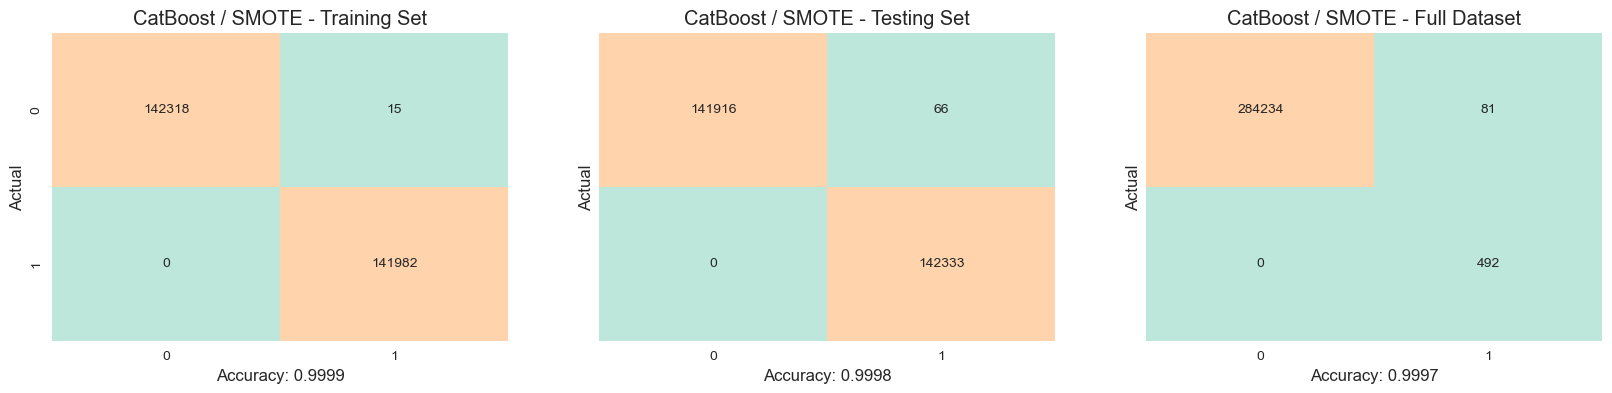

In [ ]:
# Train CatBoost model
cat_model = CatBoostClassifier(
    iterations=500,
    learning_rate=0.02,
    depth=12,
    eval_metric='AUC',
    random_seed=42,
    bagging_temperature=0.2,
    od_type='Iter',
    metric_period=100,
    od_wait=100
)

# Fit model and make predictions (using your custom Models() function)
model, y_pred = Models(cat_model, X_train, X_test, y_train, y_test, df, title="CatBoost / SMOTE")



In [ ]:
# Feature importances
imp_df = FeatureImportances(cat_model, X_train, y_train, df)
print(imp_df)

0:	total: 615ms	remaining: 5m 6s
100:	total: 1m 4s	remaining: 4m 16s
200:	total: 2m 6s	remaining: 3m 8s
300:	total: 3m 7s	remaining: 2m 3s
400:	total: 4m 5s	remaining: 1m
499:	total: 5m 1s	remaining: 0us
   Feature  Importance  Cumulative Importance
0       V4   10.558071              28.492508
1      V14    9.628263              64.363785
2     Time    6.149528               6.149528
3       V1    5.218653              11.368180
4      V12    4.703308              52.458873
5       V8    4.389547              39.213755
6      V26    4.253768              94.566676
7      V17    4.040698              74.541483
8       V3    4.002107              17.934438
9      V11    3.904972              47.755565
10     V15    3.528889              67.892674
11     V24    3.168479              87.738581
12     V10    2.685276              43.850593
13     V16    2.608112              70.500786
14     V25    2.574327              90.312908
15      V2    2.564150              13.932330
16      V6    

In [ ]:
# Full dataset
X_all, y_all = Definedata(df)

# Classification report
report = classification_report(y_all, y_pred, digits=4)
print("=== Classification Report on Full Dataset ===")
print(report)

# Get probabilities for the positive class (Class=1)
y_proba_cat = cat_model.predict_proba(X_all)[:,1]

# ROC-AUC
roc_auc_cat = roc_auc_score(y_all, y_proba_cat)
print(f"ROC AUC Score (Full Dataset): {roc_auc_cat:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(cm.shape[0])],
                     columns=[f"Pred_{i}" for i in range(cm.shape[1])])
print("Confusion Matrix (Full Dataset):")
print(cm_df)

=== Classification Report on Full Dataset ===
              precision    recall  f1-score   support

           0     1.0000    0.9997    0.9999    284315
           1     0.8586    1.0000    0.9239       492

    accuracy                         0.9997    284807
   macro avg     0.9293    0.9999    0.9619    284807
weighted avg     0.9998    0.9997    0.9997    284807

ROC AUC Score (Full Dataset): 0.99998
Confusion Matrix (Full Dataset):
          Pred_0  Pred_1
Actual_0  284234      81
Actual_1       0     492


Different from other models, this model does not rely too heavily on specific features as the feature importance table showed that 8 most importance features are just accounted for over 50% of the cumulative importance, differ from over 80% model.
Besides highly correlated and familiar features, CatBoost surprisingly recognised “Time”, V8, and V26 in the top 7 most important features. This finding shows that CatBoost, though having slightly weaker performance comparing to Random Forest and XGBoost, the score of this model might improve fraudulent transaction prediction as it considers more features. On the other hand, this result leads to the supposition that since this model treats highly correlated features more lightly than other models, its effectiveness is not as strong as Random Forest or XGBoost.

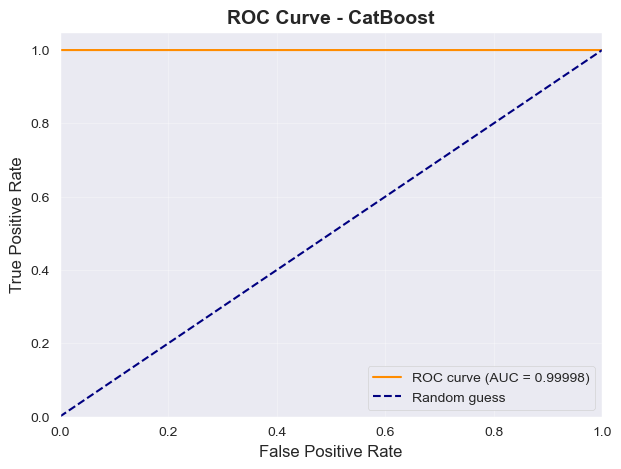

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, y_proba_cat)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc_cat:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - CatBoost', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Calculate Gini coefficient
gini_cat = 2 * roc_auc_cat - 1
print(f"Gini Coefficient of CatBoost: {gini_cat:.4f}")

Gini Coefficient of CatBoost: 1.0000


With this level of prediction, similar to Random Forest and XGBoost, CatBoost has GINI approximately 1.0000 and a highly appreciated predicting performance.

## **5.6. Light GBM**

Overall: Though it can detect all fraudulent transactions and has no false negatives, Light GBM has the lowest level of accuracy between the assessed machine learning algorithms (0.7627). The model has extremely low precision (0.0072) and F1-score (0.0144), and the scores are explained further by the confusion matrix, where 67,578 normal transactions are misclassified as fraud.  Although this yields a very high ROC AUC score of 0.9946, indicating excellent overall ranking ability, the model’s real-world applicability is limited because it would generate an excessive number of false alarms in operational settings.

In [ ]:
!pip install lightgbm
from lightgbm import LGBMClassifier

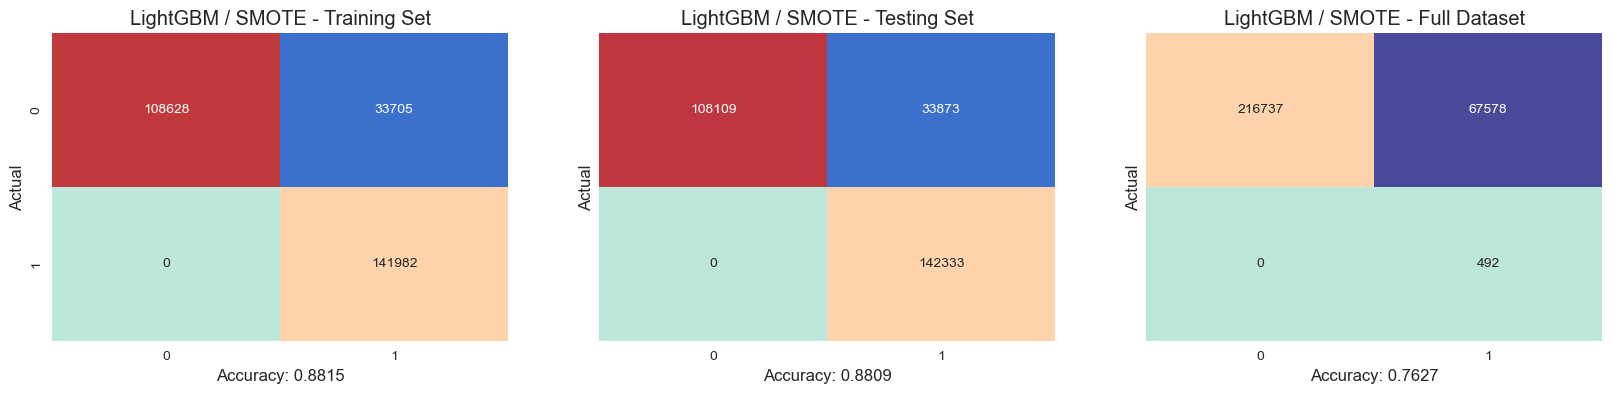

In [ ]:
# LightGBM parameters
params = {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,
    'num_leaves': 7,              # should be smaller than 2^(max_depth)
    'max_depth': 4,               # -1 means no limit
    'min_child_samples': 100,     # minimum data in one leaf
    'max_bin': 100,               # number of bins for feature values
    'subsample': 0.9,             # subsample ratio for training data
    'subsample_freq': 1,          # frequency of subsampling
    'colsample_bytree': 0.7,      # ratio of columns for each tree
    'min_child_weight': 0,        # minimum sum of instance weight in a leaf
    'min_split_gain': 0,          # minimum loss reduction required to make a split
    'nthread': 8,
    'verbose': 0,
    'scale_pos_weight': 150       # for highly imbalanced data
}

# Train LightGBM model
lgbm_model = LGBMClassifier(random_state=0, **params)

# Fit model and make predictions (using your custom Models() function)
model, y_pred = Models(lgbm_model, X_train, X_test, y_train, y_test, df, title="LightGBM / SMOTE")


In [ ]:
# Feature importances
imp_df = FeatureImportances(lgbm_model, X_train, y_train, df)
print(imp_df)

   Feature  Importance  Cumulative Importance
0       V4          95                    245
1      V14          82                    494
2       V1          52                     91
3       V8          48                    308
4      V12          47                    404
5       V3          43                    150
6     Time          39                     39
7      V10          30                    341
8      V11          16                    357
9       V2          16                    107
10     V18          15                    527
11     V19          11                    538
12     V25          10                    583
13     V16          10                    506
14      V5           9                    254
15     V13           8                    412
16     V20           8                    546
17     V22           8                    561
18     V24           7                    573
19     V26           7                    590
20     V21           7            

In [ ]:
# Full dataset
X_all, y_all = Definedata(df)

# classification report
report = classification_report(y_all, y_pred, digits=4)
print("Classification Report (Full Dataset)")
print(report)

# Get probabilities for the positive class (Class=1)
y_proba_lgbm = lgbm_model.predict_proba(X_all)[:,1]

# ROC-AUC
roc_auc_lgbm = roc_auc_score(y_all, y_proba_lgbm)
print(f"ROC AUC Score (Full Dataset): {roc_auc:.5f}")

# Confusion Matrix
cm = confusion_matrix(y_all, y_pred)
cm_df = pd.DataFrame(cm, index=[f"Actual_{i}" for i in range(cm.shape[0])],
                     columns=[f"Pred_{i}" for i in range(cm.shape[1])])
print("Confusion Matrix (Full Dataset):")
print(cm_df)

Classification Report (Full Dataset)
              precision    recall  f1-score   support

           0     1.0000    0.7623    0.8651    284315
           1     0.0072    1.0000    0.0144       492

    accuracy                         0.7627    284807
   macro avg     0.5036    0.8812    0.4397    284807
weighted avg     0.9983    0.7627    0.8637    284807

ROC AUC Score (Full Dataset): 0.95497
Confusion Matrix (Full Dataset):
          Pred_0  Pred_1
Actual_0  216737   67578
Actual_1       0     492


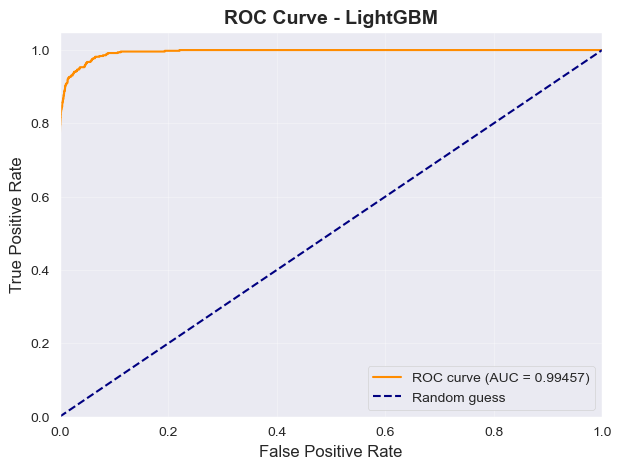

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, y_proba_lgbm)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc_lgbm:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - LightGBM', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

In [ ]:
# Calculate Gini coefficient
gini_lgbm = 2 * roc_auc_lgbm - 1
print(f"Gini Coefficient of CatBoost: {gini_lgbm:.4f}")

Gini Coefficient of CatBoost: 0.9891


The feature importance table for Light GBM shows the split importance, or the number of times the model used each feature to split data. In total, the model split 600 times, the top 11 accounts for 487 times or 80% number the needed time splits. Besides familiar highly correlated features, the other important ones are V8, ‘Time’, and V2.

The ROC curve illustrates that the Light GBM is still considered as effective method for fraud detection. The model achieves a GINI of 0.0.99457, approaching 1, indicating a relatively strong level of discriminatory power between fraudulent and legitimate cases.

**Summary of supervised learning methods**

 The results of supervised learning algorithms are much more precise than unsupervised ones. The Random Forest so far is the best performing model with the highest F1-score (0.9685), and according to its confusion matrix, there are no false negatives and 32 false positives. XGBoots and CatBoots both have good recalls and no false negatives, but XGBoots slightly performs better than CatBoots with higher Precision (1) and F1-score (1). On the other hand, AdaBoost and LightGBM have really poor overall balance with F1-score (1) equal to 0.1598 and 0.0144, respectively. LightGBM is the worst-performing with extremely low Precision (1) (0.0072), which is even lower than the Anomaly detection models’ performances, reflecting severe overprediction of the minority class. Furthermore, the results also showed that the most important features for the models are likely the ones that have better correlations with ‘Class’, but not all listed high correlation features have great contributions to the Machine Learning model. Therefore, the outcomes of detecting fraudulent transactions on highly correlated data frames are significantly worse than using the whole original one, indicating that the whole dataframe must be used as an input for machine learning methods and hybrid methods that are based on supervised algorithms.

# **6. Hybrid model**

Overall: Hybrid models that integrate both supervised and unsupervised learning methods were built and showed a better result in fraud detection for this data frame (Shanaa M and Abdallah M, 2025; Tayab). Under the scope of this project, the chosen methods include Isolation Forest, Autoencoder for unsupervised learning, and Random Forest, XGBoost, and CatBoost for supervised learning. Supervised algorithms, such as Random Forest and XGBoost, are used to learn from labelled data and recognize known fraud patterns, while unsupervised algorithms like Isolation Forest and Autoencoder detect abnormal or unseen behaviours through anomaly and reconstruction error analysis. The outputs of these models are then combined and fed into a Logistic Regression meta-classifier, which learns the optimal balance between them. This hybrid approach enhances adaptability, precision, and robustness, enabling the system to detect both historical and emerging fraud effectively. Since fraud detection performed better on a modified data frame with highly correlated variables, the project also tested Hybrid Model 2 using unsupervised method scores from this data frame. The result shows that this approach can increase accuracy, lower the false positive rate, increase the F1-score (0) to 1.00, and the F1-score (1) to 0.9801 with only 20 false positives. Hybrid Model 1 and 2 have the same performance, just different thresholds (0.6100 and 0.5970). 

## **6.1. Hybrid model with full dataset**

In [ ]:
# Use output from Isolation Forest
iso_scores = - iso_forest.decision_function(X_scaled)

# Use reconstruction error from Autoencoder
reconstructions = autoencoder.predict(X_scaled)
ae_mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 19s 2ms/step


In [ ]:
# Combine the anomative detection score into the dataframe
df_processed = pd.DataFrame(X_scaled, columns=features)
df_processed['iso_score'] = iso_scores
df_processed['ae_mse'] = ae_mse

# Combine the machine learning result into the dataframe
df_processed['xgb_pred'] = xgb_model.predict_proba(X_all)[:, 1]
df_processed['rf_pred']  = rf_model.predict_proba(X_all)[:, 1]
df_processed['cat_pred'] = cat_model.predict_proba(X_all)[:, 1]

In [ ]:
# Create hybrid features set that include the predict results
hybrid_features = df_processed[['iso_score', 'ae_mse', 'xgb_pred', 'rf_pred', 'cat_pred']]

# Train meta-classifier (Logistic Regression)
meta_model = LogisticRegression()
meta_model.fit(hybrid_features, y)

LogisticRegression()

In [ ]:
# Predict probability of class 1 (fraud)
hybrid_probs = meta_model.predict_proba(hybrid_features)[:, 1]

Best threshold based on F1 for hybrid model: 0.6100
Classification Report
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000    284315
           1     0.9609    1.0000    0.9801       492

    accuracy                         0.9999    284807
   macro avg     0.9805    1.0000    0.9900    284807
weighted avg     0.9999    0.9999    0.9999    284807

ROC-AUC Score: 0.99999


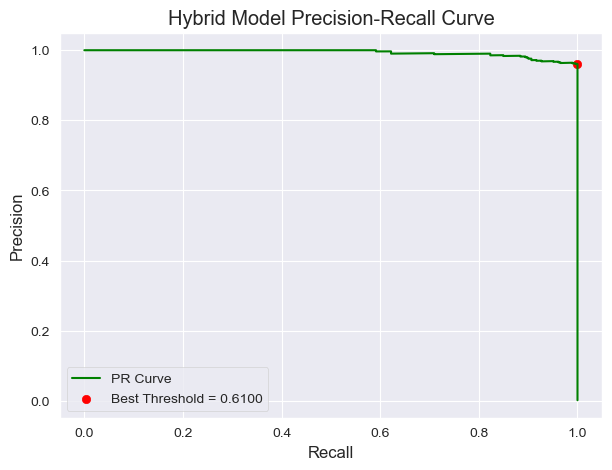

In [ ]:
# Find precision, recall và thresholds
precision, recall, thresholds = precision_recall_curve(y, hybrid_probs)

# Find F1-score for threshold
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-10)

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold based on F1 for hybrid model: {best_threshold:.4f}")

# Predict labels by best threshold
hybrid_pred_labels = (hybrid_probs >= best_threshold).astype(int)

# In classification report
print("Classification Report")
print(classification_report(y, hybrid_pred_labels, digits=4))

# ROC-AUC
roc_auc = roc_auc_score(y, hybrid_probs)
print(f"ROC-AUC Score: {roc_auc:.5f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='green', label='PR Curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Hybrid Model Precision-Recall Curve')
plt.legend()
plt.show()

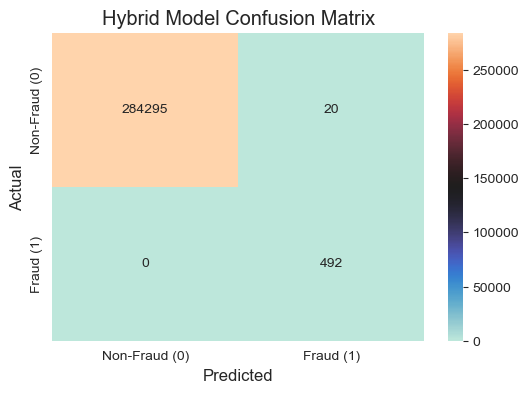

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y, hybrid_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Hybrid Model Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

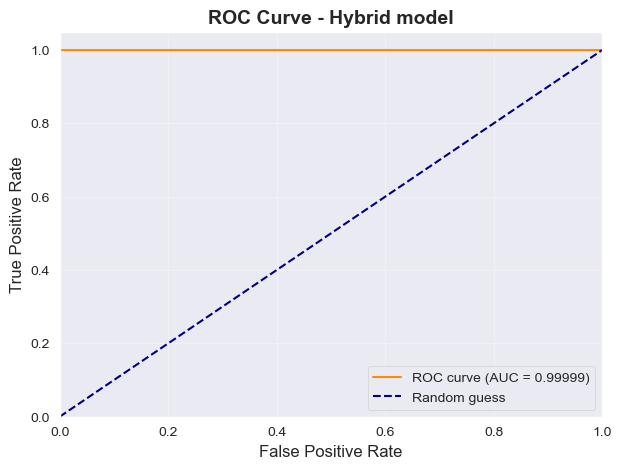

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, hybrid_probs)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Hybrid model', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

## **6.2. Example of predicting a transaction with this model**

In [ ]:
# Pick a transaction from the dataframe
transaction = df.iloc[[105]].iloc[:, :-1]
print(transaction)

     Time        V1        V2        V3        V4        V5        V6  \
105  69.0 -2.220642  1.029181 -0.697724 -1.268226  2.802221  3.322901   

           V7        V8        V9  ...      V20       V21       V22       V23  \
105  0.197036 -0.521297  0.859596  ... -0.11153  0.110448 -1.178463  0.508911   

          V24       V25       V26       V27       V28  Amount  
105  0.923385  0.213759  0.033507 -0.142025 -0.263844    9.47  

[1 rows x 30 columns]


In [ ]:
def predict_transaction(transaction, scaler, iso_forest, autoencoder,
                            xgb_model, rf_model, cat_model, meta_model, best_threshold):
    # Scale
    X_scaled_new = scaler.transform(transaction)

    # Anomaly scores
    iso_score_new = -iso_forest.decision_function(X_scaled_new)[0]
    reconstruction_new = autoencoder.predict(X_scaled_new)
    ae_mse_new = np.mean(np.power(X_scaled_new - reconstruction_new, 2))

    # Supervised predictions
    xgb_pred_new = xgb_model.predict_proba(X_scaled_new)[:, 1][0]
    rf_pred_new  = rf_model.predict_proba(X_scaled_new)[:, 1][0]
    cat_pred_new = cat_model.predict_proba(X_scaled_new)[:, 1][0]

    # Hybrid vector
    hybrid_vector_new = np.array([[iso_score_new, ae_mse_new, xgb_pred_new, rf_pred_new, cat_pred_new]])

    # Meta model prediction
    prob_new = meta_model.predict_proba(hybrid_vector_new)[:, 1][0]
    label_new = int(prob_new >= best_threshold)

    return {
        "iso_score": iso_score_new,
        "ae_mse": ae_mse_new,
        "xgb_pred": xgb_pred_new,
        "rf_pred": rf_pred_new,
        "cat_pred": cat_pred_new,
        "hybrid_prob": prob_new,
        "predicted_label": label_new,
        "result": "FRAUD" if label_new==1 else "NON-FRAUD"
    }

# Usage
result = predict_transaction(transaction, scaler, iso_forest, autoencoder,
                                 xgb_model, rf_model, cat_model, meta_model, best_threshold)

print(result)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
{'iso_score': np.float64(0.007253403387947666), 'ae_mse': np.float64(0.04523819418918071), 'xgb_pred': np.float32(1.8195233e-06), 'rf_pred': np.float64(0.01), 'cat_pred': np.float64(0.00020015775559480717), 'hybrid_prob': np.float64(4.871344216687655e-05), 'predicted_label': 0, 'result': 'NON-FRAUD'}


## **6.3. Hybrid model inputs from applying Unsupervised methods with only high correlated features**

In [ ]:
# Use output from Isolation Forest
iso_imp_scores = - iso_forest_imp.decision_function(Z_scaled)

# Calculate reconstruction error for all transactions
reconstructed_imp = autoencoder_imp.predict(Z_scaled)
ae_mse_imp = np.mean(np.power(Z_scaled - reconstructed_imp, 2), axis=1)

8901/8901 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step


In [ ]:
# Combine the anomative detection score into the dataframe
df_imp_processed = pd.DataFrame(X_scaled, columns=features)
df_imp_processed['iso_imp_score'] = iso_imp_scores
df_imp_processed['ae_mse_imp'] = ae_mse_imp

# Combine the machine learning result into the dataframe
df_imp_processed['xgb_pred'] = xgb_model.predict_proba(X_all)[:, 1]
df_imp_processed['rf_pred']  = rf_model.predict_proba(X_all)[:, 1]
df_imp_processed['cat_pred'] = cat_model.predict_proba(X_all)[:, 1]

In [ ]:
df_imp_processed.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V25,V26,V27,V28,Amount,iso_imp_score,ae_mse_imp,xgb_pred,rf_pred,cat_pred
0,0.000000,0.603329,0.568680,0.827359,0.313023,0.534965,0.483822,0.466600,0.598640,0.475312,...,0.585122,0.394557,0.494419,0.437517,0.493873,-0.096648,0.008200,2.593828e-05,0.00,0.009689
1,0.000000,0.913978,0.609850,0.649577,0.271796,0.576993,0.423477,0.432795,0.596946,0.453981,...,0.587290,0.446013,0.474206,0.443100,0.128583,-0.125139,0.004869,8.898125e-05,0.00,0.000217
2,0.000006,0.603445,0.463820,0.788393,0.268766,0.521003,0.569201,0.509432,0.615936,0.410603,...,0.559515,0.402727,0.467443,0.431659,0.584923,-0.047575,0.012505,3.374158e-06,0.00,0.000536
3,0.000006,0.637817,0.555279,0.789533,0.213661,0.568756,0.540277,0.466414,0.629394,0.414999,...,0.614245,0.389197,0.484707,0.450191,0.475117,-0.081274,0.008289,6.509570e-07,0.00,0.000034
4,0.000012,0.620208,0.662831,0.774862,0.269796,0.528934,0.445914,0.495771,0.553269,0.490950,...,0.566343,0.507497,0.505407,0.471486,0.419792,-0.107677,0.008037,1.668062e-07,0.01,0.001001


In [ ]:
# Create hybrid features set that include the predict results
hybrid_imp_features = df_imp_processed[['iso_imp_score', 'ae_mse_imp', 'xgb_pred', 'rf_pred','cat_pred']]

# Train meta-classifier (Logistic Regression)
meta_imp_model = LogisticRegression()
meta_imp_model.fit(hybrid_imp_features, y)

LogisticRegression()

In [ ]:
# Predict probability of class 1 (fraud)
hybrid_imp_probs = meta_imp_model.predict_proba(hybrid_imp_features)[:, 1]

Best threshold based on F1 for hybrid model: 0.5970
=== Classification Report ===
              precision    recall  f1-score   support

           0     1.0000    0.9999    1.0000    284315
           1     0.9609    1.0000    0.9801       492

    accuracy                         0.9999    284807
   macro avg     0.9805    1.0000    0.9900    284807
weighted avg     0.9999    0.9999    0.9999    284807

ROC-AUC Score: 0.99999


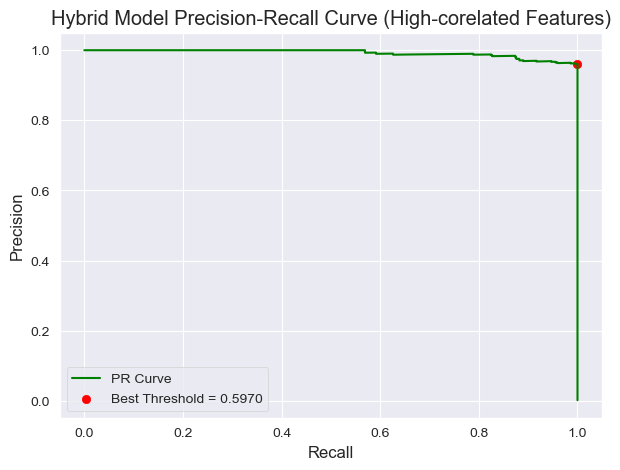

In [ ]:
# Find precision, recall và thresholds
precision, recall, thresholds = precision_recall_curve(y, hybrid_imp_probs)

# Find F1-score for threshold
f1_scores = 2 * precision[:-1] * recall[:-1] / (precision[:-1] + recall[:-1] + 1e-10)

# Find best threshold
best_idx = np.argmax(f1_scores)
best_threshold = thresholds[best_idx]
print(f"Best threshold based on F1 for hybrid model: {best_threshold:.4f}")

# Predict labels by best threshold
hybrid_imp_pred_labels = (hybrid_imp_probs >= best_threshold).astype(int)

# In classification report
print("Classification Report")
print(classification_report(y, hybrid_imp_pred_labels, digits=4))

# ROC-AUC
roc_auc_hybrid_imp = roc_auc_score(y, hybrid_imp_probs)
print(f"ROC-AUC Score: {roc_auc_hybrid_imp:.5f}")

# Plot Precision-Recall Curve
plt.figure(figsize=(7,5))
plt.plot(recall, precision, color='green', label='PR Curve')
plt.scatter(recall[best_idx], precision[best_idx], color='red',
            label=f'Best Threshold = {best_threshold:.4f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Hybrid Model Precision-Recall Curve (High-corelated Features)')
plt.legend()
plt.show()

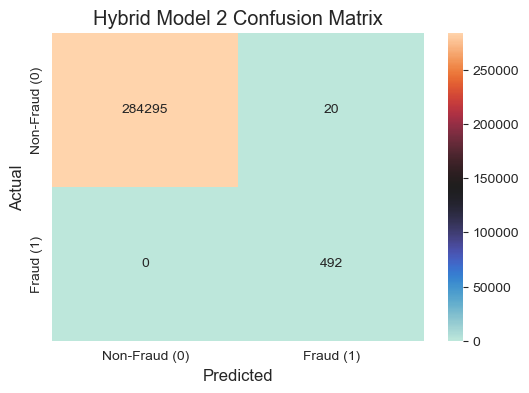

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y, hybrid_imp_pred_labels)

# Plot the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, cmap="icefire", fmt='g')

# Add labels, title, and axis ticks
plt.title('Hybrid Model 2 Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

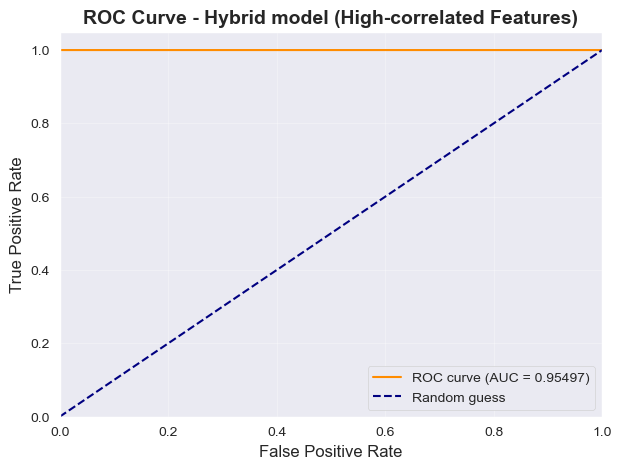

In [ ]:
# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_all, hybrid_imp_pred_labels)

# Plot ROC curve
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (AUC = {roc_auc:.5f})')
plt.plot([0,1], [0,1], color='navy', linestyle='--', label='Random guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve - Hybrid model (High-correlated Features)', fontsize=14, fontweight='bold')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

As mentioned earlier, focusing on highly correlated features appears to help Unsupervised Learning methods detect fraudulent transactions. Therefore, when exploring a hybrid approach to fraud detection, our group chose to evaluate the performance of models that include scores generated from training unsupervised models on both the full original dataset and the high-correlated subset. Meanwhile, all supervised model scores are based solely on outputs from training on the SMOTE-augmented dataset.
Using comprehensive results from different models has improved the outcome of fraud detection. This new combined approach can detect all fraud transactions while increasing the precision (0.9609) and F1-score (0.9801). Looking further into the confusion matrix, the model has just made 20 false positives without any false negatives.  
The model uses output from training anomaly detection models on a dataset with only highly correlated features, shows the same performance; the only difference is the best threshold.